In [1]:
!pip install cudf
import numpy as np
import pandas as pd 
from datetime import datetime, timedelta
import gc
import cudf
import cv2, matplotlib.pyplot as plt
from os.path import exists

### Read the transactions data

Changes: 
* read_csv using cudf
* article_id types from string to int32 
* reduce memory on customer_id 

In [2]:
Date_week1 = pd.to_datetime("2020-09-16")
Date_week2 = pd.to_datetime("2020-09-09")
Date_week3 = pd.to_datetime("2020-09-02")
Last_day = pd.to_datetime("2020-09-22")

In [3]:
N = 12

In [4]:
df  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
                            #usecols= ['t_dat', 'customer_id', 'article_id'], 
                            #dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string', "sales_channel_id": 'int32', "price": "float"})
df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')
df.article_id = df.article_id.astype('int32')
df['t_dat'] = cudf.to_datetime(df['t_dat'])
Last_date = df['t_dat'].max()

In [5]:
df

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.050831,2
1,2018-09-20,-6846340800584936,541518023,0.030492,2
2,2018-09-20,-8334631767138808638,505221004,0.015237,2
3,2018-09-20,-8334631767138808638,685687003,0.016932,2
4,2018-09-20,-8334631767138808638,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,4685485978980270934,929511001,0.059305,2
31788320,2020-09-22,4685485978980270934,891322004,0.042356,2
31788321,2020-09-22,3959348689921271969,918325001,0.043203,1
31788322,2020-09-22,-8639340045377511665,833459002,0.006763,1


## 划分训练集和验证集

In [6]:
val = df[df['t_dat']>= Date_week1].copy()
train = df[df['t_dat']< Date_week1].copy()
Last_date = pd.to_datetime("2020-09-15")

In [7]:
val

,t_dat,customer_id,article_id,price,sales_channel_id
31548013,2020-09-16,8055340703569116761,786022008,0.048441,2
31548014,2020-09-16,8055340703569116761,913272003,0.032288,2
31548015,2020-09-16,8055340703569116761,889669006,0.056508,2
31548016,2020-09-16,2563761487478961358,237347060,0.033881,1
31548017,2020-09-16,2563761487478961358,562245001,0.013542,1
...,...,...,...,...,...
31788319,2020-09-22,4685485978980270934,929511001,0.059305,2
31788320,2020-09-22,4685485978980270934,891322004,0.042356,2
31788321,2020-09-22,3959348689921271969,918325001,0.043203,1
31788322,2020-09-22,-8639340045377511665,833459002,0.006763,1


### Add the last day of billing week

## 第一路：复购预测

In [8]:
df = train.copy()

In [9]:
%%time
tmp = df[['t_dat']].copy().to_pandas()
tmp['dow'] = tmp['t_dat'].dt.dayofweek
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')
df['ldbw'] = tmp['ldbw'].values

CPU times: user 6.38 s, sys: 1.67 s, total: 8.05 s
Wall time: 7.92 s


In [10]:
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

In [11]:
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')

### Let's assume that in the target week sales will be similar to the last week of the training data

In [12]:
weekly_sales = weekly_sales.reset_index().set_index('article_id')

df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==Last_date, ['count']],
    on='article_id', suffixes=("", "_targ"))

df['count_targ'].fillna(0, inplace=True)


### Calculate sales rate adjusted for changes in product popularity 

In [13]:
df['quotient'] = df['count_targ'] / df['count']

### Take supposedly popular products

In [14]:
# target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
# general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
# general_pred = ['0' + str(article_id) for article_id in general_pred]
# general_pred_str =  ' '.join(general_pred)
# del target_sales

In [15]:
# general_pred # Exactly same with the original notebook! 

In [16]:
# general_pred_str

### Fill in purchase dictionary

In [17]:
%%time
purchase_dict = {}

tmp = df.copy().to_pandas()
tmp['x'] = ((Last_date - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
total = 1715530
tmp['y'] = ((a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d) / total +\
(a / np.sqrt(tmp['x']+1) + b * np.exp(-c*(tmp['x']+1)) - d) / total +\
(a / np.sqrt(tmp['x']+2) + b * np.exp(-c*(tmp['x']+2)) - d) / total +\
(a / np.sqrt(tmp['x']+3) + b * np.exp(-c*(tmp['x']+3)) - d) / total +\
(a / np.sqrt(tmp['x']+4) + b * np.exp(-c*(tmp['x']+4)) - d) / total +\
(a / np.sqrt(tmp['x']+5) + b * np.exp(-c*(tmp['x']+5)) - d) / total +\
(a / np.sqrt(tmp['x']+6) + b * np.exp(-c*(tmp['x']+6)) - d) / total)

tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
tmp['score'] = tmp['quotient'] * tmp['y'] 

tmp = tmp.groupby(['customer_id', 'article_id']).agg({'score': 'sum'})
tmp = tmp.reset_index()

tmp = tmp.loc[tmp['score'] > 0]
tmp['rank'] = tmp.groupby("customer_id")["score"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]
tmp["source"] = 1

result1 = tmp[["customer_id", "article_id", "source", "score", "rank"]]

CPU times: user 16.3 s, sys: 5.4 s, total: 21.7 s
Wall time: 20.1 s


In [18]:
del weekly_sales
del df
del tmp
gc.collect()

208

In [19]:
result1

,customer_id,article_id,source,score,rank
0,-9223352921020755230,568597006,1,0.000559,5.0
1,-9223352921020755230,673396002,1,0.044511,1.0
2,-9223352921020755230,706016001,1,0.003289,4.0
3,-9223352921020755230,812167004,1,0.019179,2.0
4,-9223352921020755230,849493006,1,0.006174,3.0
...,...,...,...,...,...
10844244,9223301031927667525,719957006,1,0.000026,1.0
10844245,9223333063893176977,658030020,1,0.000038,1.0
10844246,9223357421094039679,747984001,1,0.000010,2.0
10844247,9223357421094039679,747984002,1,0.000053,1.0


In [20]:
#result1.to_csv("/kaggle/working/result1.csv", index = False)

## 第二路：相似复购

In [21]:
!pip install cudf
import numpy as np
import pandas as pd 
from datetime import datetime, timedelta
import gc
import cudf
import cv2, matplotlib.pyplot as plt
from os.path import exists

In [22]:
# # LOAD TRANSACTIONS DATAFRAME
# df = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
# print('Transactions shape',df.shape)
# display( df.head() )

# # REDUCE MEMORY OF DATAFRAME
# df = df[['customer_id','article_id']]
# df.customer_id = df.customer_id.str[-16:].str.hex_to_int().astype('int64')
# df.article_id = df.article_id.astype('int32')
# _ = gc.collect()

In [23]:
# # FIND ITEMS PURCHASED TOGETHER
# vc = df.article_id.value_counts()
# pairs = {}
# # for j,i in enumerate(vc.index.values[1000:1032]):
# #     #if j%10==0: print(j,', ',end='')
# #     USERS = df.loc[df.article_id==i.item(),'customer_id'].unique()
# #     vc2 = df.loc[(df.customer_id.isin(USERS))&(df.article_id!=i.item()),'article_id'].value_counts()
# #     pairs[i.item()] = [vc2.index[0], vc2.index[1], vc2.index[2]]

In [24]:
# vc = vc.reset_index().rename(columns = {"article_id":"count", "index":"article_id"})

In [25]:
# vc = vc[vc["count"]>=50]

In [26]:
# def cal_together_score(x):
#     USERS = df.loc[df.article_id==x["article_id"],'customer_id'].unique()
#     vc2 = df.loc[(df.customer_id.isin(USERS))&(df.article_id!=x["article_id"]),'article_id'].value_counts()
#     #pairs[i.item()] = [vc2.index[0], vc2.index[1], vc2.index[2]]
#     return [[x.article_id, vc2.index[i], vc2.iloc[i]/x["count"]] for i in range(min(10, len(vc2)))]

In [27]:
#relation = vc.to_pandas().apply(lambda x: cal_together_score(x), axis = 1).sum()

In [28]:
#%%time
# df  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
#                             usecols= ['t_dat', 'customer_id', 'article_id'], 
#                             dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
# df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')

# df['t_dat'] = cudf.to_datetime(df['t_dat'])
# last_ts = df['t_dat'].max()

In [29]:
df = train.copy()

In [30]:
%%time
tmp = df[['t_dat']].copy().to_pandas()
tmp['dow'] = tmp['t_dat'].dt.dayofweek
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

df['ldbw'] = tmp['ldbw'].values

CPU times: user 6.28 s, sys: 1.59 s, total: 7.86 s
Wall time: 7.72 s


In [31]:
#relation_data = cudf.DataFrame(relation, columns = ["from_id", "to_id", "ratio"])

In [32]:
relation_data = cudf.read_csv("../input/relation/relation_data.csv")

In [33]:
relation_data

,from_id,to_id,ratio
0,706016001,706016002,0.250144
1,706016001,706016003,0.155706
2,706016001,706016015,0.117943
3,706016001,706016006,0.097799
4,706016001,399223001,0.087299
...,...,...,...
570535,657165029,763270003,0.120000
570536,657165029,628327005,0.120000
570537,657165029,664319001,0.120000
570538,657165029,608776002,0.100000


In [34]:
del tmp
gc.collect()

106

In [35]:
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

In [36]:
weekly_sales

,ldbw,article_id,count,price,sales_channel_id
0,2019-03-12,719447002,4,4,4
1,2019-04-16,590203002,1,1,1
2,2020-05-05,831684001,12,12,12
3,2019-05-28,693508002,1,1,1
4,2019-07-02,777038001,5,5,5
...,...,...,...,...,...
2183240,2019-02-12,664871001,34,34,34
2183241,2019-11-19,640735001,2,2,2
2183242,2018-10-02,569355002,6,6,6
2183243,2019-06-04,684021006,8,8,8


In [37]:
df = df[df["ldbw"] >= pd.to_datetime('2020-08-01')]

In [38]:
full_result = df.merge(relation_data, left_on = "article_id", right_on = "from_id")

In [39]:
full_result.drop(["article_id", "from_id"], axis = 1, inplace = True)

In [40]:
full_result = full_result.rename(columns = {"to_id": "article_id"})

In [41]:
full_result

,t_dat,customer_id,price,sales_channel_id,ldbw,article_id,ratio
0,2020-07-29,-6007016008589505382,0.030492,2,2020-08-04,811927007,0.298737
1,2020-07-29,-6007016008589505382,0.022017,2,2020-08-04,811925009,0.407963
2,2020-07-29,-6007016008589505382,0.025407,2,2020-08-04,913030001,0.209235
3,2020-07-29,-56930136629560914,0.030492,2,2020-08-04,706016002,0.069138
4,2020-07-29,-6007016008589505382,0.030492,2,2020-08-04,811927007,0.298737
...,...,...,...,...,...,...,...
18750425,2020-09-15,5071616147837568152,0.050831,1,2020-09-15,779333004,0.064356
18750426,2020-09-15,4908528897358301336,0.042356,2,2020-09-15,922381001,0.140351
18750427,2020-09-15,4908528897358301336,0.042356,2,2020-09-15,706016015,0.099415
18750428,2020-09-15,4908528897358301336,0.042356,2,2020-09-15,572998001,0.093567


In [42]:
full_result = full_result.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')

In [43]:
#full_result.drop(["article_id", "from_id", "count"], axis = 1, inplace = True)

In [44]:
#full_result.dropna(inplace)

In [45]:
weekly_sales = weekly_sales.reset_index().set_index('article_id')

full_result = full_result.merge(
    weekly_sales.loc[weekly_sales['ldbw']==Last_date, ['count']],
    on='article_id', suffixes=("", "_targ"))

full_result['count_targ'].fillna(0, inplace=True)

In [46]:
full_result

,t_dat,customer_id,price_x,sales_channel_id_x,ldbw,article_id,ratio,count,price_y,sales_channel_id_y,count_targ
0,2020-07-30,6896914372120773055,0.033881,2,2020-08-04,578630002,0.260073,18,18,18,1
1,2020-07-30,6896914372120773055,0.033881,2,2020-08-04,578630002,0.260073,18,18,18,1
2,2020-07-30,6896914372120773055,0.008458,2,2020-08-04,610776002,0.291486,208,208,208,206
3,2020-07-30,6896914372120773055,0.008458,2,2020-08-04,610776002,0.291486,208,208,208,206
4,2020-07-30,6896914372120773055,0.008458,2,2020-08-04,610776002,0.291486,208,208,208,206
...,...,...,...,...,...,...,...,...,...,...,...
17558330,2020-09-15,5155332850937327809,0.022017,2,2020-09-15,749699002,0.048544,46,46,46,46
17558331,2020-09-15,6102711561480693254,0.025407,1,2020-09-15,706016002,0.060847,373,373,373,373
17558332,2020-09-15,-2458382469734728316,0.050831,2,2020-09-15,751471001,0.093750,607,607,607,607
17558333,2020-09-15,-8028414168786311693,0.050831,2,2020-09-15,610776002,0.059288,206,206,206,206


In [47]:
full_result['quotient'] = full_result['count_targ'] / full_result['count']

In [48]:
%%time
purchase_dict = {}

tmp = full_result.copy().to_pandas()
tmp['x'] = ((Last_date - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
total = 1715530
tmp['y'] = ((a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d) / total +\
(a / np.sqrt(tmp['x']+1) + b * np.exp(-c*(tmp['x']+1)) - d) / total +\
(a / np.sqrt(tmp['x']+2) + b * np.exp(-c*(tmp['x']+2)) - d) / total +\
(a / np.sqrt(tmp['x']+3) + b * np.exp(-c*(tmp['x']+3)) - d) / total +\
(a / np.sqrt(tmp['x']+4) + b * np.exp(-c*(tmp['x']+4)) - d) / total +\
(a / np.sqrt(tmp['x']+5) + b * np.exp(-c*(tmp['x']+5)) - d) / total +\
(a / np.sqrt(tmp['x']+6) + b * np.exp(-c*(tmp['x']+6)) - d) / total)

tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
tmp['score'] = tmp['quotient'] * tmp['y'] * tmp["ratio"]

tmp = tmp.groupby(['customer_id', 'article_id']).agg({'score': 'sum'})
tmp = tmp.reset_index()

tmp = tmp.loc[tmp['score'] > 0]
tmp['rank'] = tmp.groupby("customer_id")["score"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]
tmp["source"] = 2

result2 = tmp[["customer_id", "article_id", "source", "score", "rank"]]

CPU times: user 18.3 s, sys: 7.05 s, total: 25.4 s
Wall time: 23.6 s


In [49]:
#result2.to_csv("result2.csv", index = False)

In [50]:
del tmp
del df
del full_result
gc.collect()

42

In [51]:
#relation_data.to_csv("/kaggle/working/relation_data.csv", index = False)

In [52]:
# items = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
# BASE = '../input/h-and-m-personalized-fashion-recommendations/images/'

# for i,(k,v) in enumerate( pairs.items() ):
#     name1 = BASE+'0'+str(k)[:2]+'/0'+str(k)+'.jpg'
#     name2 = BASE+'0'+str(v[0])[:2]+'/0'+str(v[0])+'.jpg'
#     name3 = BASE+'0'+str(v[1])[:2]+'/0'+str(v[1])+'.jpg'
#     name4 = BASE+'0'+str(v[2])[:2]+'/0'+str(v[2])+'.jpg'
#     if exists(name1) & exists(name2) & exists(name3) & exists(name4):
#         plt.figure(figsize=(20,5))
#         img1 = cv2.imread(name1)[:,:,::-1]
#         img2 = cv2.imread(name2)[:,:,::-1]
#         img3 = cv2.imread(name3)[:,:,::-1]
#         img4 = cv2.imread(name4)[:,:,::-1]
#         plt.subplot(1,4,1)
#         plt.title('When customers buy this',size=18)
#         plt.imshow(img1)
#         plt.subplot(1,4,2)
#         plt.title('They buy this',size=18)
#         plt.imshow(img2)
#         plt.subplot(1,4,3)
#         plt.title('They buy this',size=18)
#         plt.imshow(img3)
#         plt.subplot(1,4,4)
#         plt.title('They buy this',size=18)
#         plt.imshow(img4)
#         plt.show()
#     #if i==63: break

In [53]:
result2

,customer_id,article_id,source,score,rank
0,-9223352921020755230,156231001,2,0.002209,12.0
1,-9223352921020755230,372860001,2,0.003020,8.0
2,-9223352921020755230,372860002,2,0.002471,11.0
3,-9223352921020755230,448509014,2,0.003171,7.0
5,-9223352921020755230,562245046,2,0.002872,9.0
...,...,...,...,...,...
10385327,9223144259947635662,719957006,2,0.008230,12.0
10385329,9223144259947635662,720504004,2,0.021830,2.0
10385330,9223144259947635662,720504007,2,0.016236,5.0
10385333,9223144259947635662,730863005,2,0.014194,6.0


## 第三路：分层上周热门（+趋势）

In [54]:
!pip install cudf
import numpy as np
import pandas as pd 
from datetime import datetime, timedelta
import gc
import cudf
import cv2, matplotlib.pyplot as plt
from os.path import exists

In [55]:
# # LOAD TRANSACTIONS DATAFRAME
# df = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
# print('Transactions shape',df.shape)
# display( df.head() )

# # REDUCE MEMORY OF DATAFRAME
# df = df[['t_dat','customer_id','article_id']]
# df.customer_id = df.customer_id.str[-16:].str.hex_to_int().astype('int64')
# df.article_id = df.article_id.astype('int32')
# df.t_dat = cudf.to_datetime(df.t_dat)
# _ = gc.collect()

In [56]:
df = train.copy()

In [57]:
customer = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv')
customer.customer_id = customer.customer_id.str[-16:].str.hex_to_int().astype('int64')

In [58]:
sales = cudf.merge(df, customer, on = "customer_id", how = 'left')
sales = sales[sales.t_dat >= Date_week2]

In [59]:
sales = sales.fillna(0)

<AxesSubplot:>

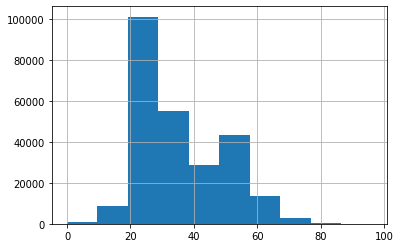

In [60]:
sales.to_pandas()["age"].hist()

In [61]:
sales

,t_dat,customer_id,article_id,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
31267104,2020-09-09,-2156777441294618063,685814005,0.033881,2,1.0,1.0,ACTIVE,Regularly,29.0,17d0433ebad432976929d99192315d2479bfb7696af1d2...
31267105,2020-09-09,-6489422566283592999,865240002,0.008458,1,0.0,0.0,ACTIVE,NONE,27.0,09b4c331056fc94bc83a021f44470ea9e859209123e09f...
31267106,2020-09-09,-7761469595989510297,868641002,0.033881,2,1.0,1.0,ACTIVE,Regularly,22.0,64c420881b31267fd17d03e2aafac8e9ef0bae5a115446...
31267107,2020-09-09,-2912203858579140439,867966010,0.033881,2,1.0,1.0,ACTIVE,Regularly,24.0,e42c4f19dc1b95b82eae4d77106924e07fef6c5c1dd4c3...
31267108,2020-09-09,-2156777441294618063,896343002,0.033881,2,1.0,1.0,ACTIVE,Regularly,29.0,17d0433ebad432976929d99192315d2479bfb7696af1d2...
...,...,...,...,...,...,...,...,...,...,...,...
31548008,2020-09-15,-6548724319026074057,780314001,0.067780,2,0.0,0.0,ACTIVE,NONE,26.0,39d90bfe73e5f0bc0a58bca8fc789182955d059fb79009...
31548009,2020-09-15,-7010773389724270175,706016002,0.033881,1,1.0,1.0,ACTIVE,Regularly,21.0,2020d6a589f9878e20886e17483107cac447bdbb31b19c...
31548010,2020-09-15,-6548724319026074057,875272003,0.050831,2,0.0,0.0,ACTIVE,NONE,26.0,39d90bfe73e5f0bc0a58bca8fc789182955d059fb79009...
31548011,2020-09-15,5919649889604164626,898692003,0.067780,2,1.0,1.0,ACTIVE,Regularly,23.0,caefb055d2000ea61aaef5e6d472874d72b88c370514ef...


In [62]:
target_sales = sales[["article_id", "customer_id"]].groupby('article_id')["customer_id"].count()
general_pred = target_sales.nlargest(N, keep = "first").index.to_pandas().tolist()
general_pred = ['0' + str(article_id) for article_id in general_pred]
general_pred_str =  ' '.join(general_pred)
del target_sales

In [63]:
general_pred_str

'0909370001 0865799006 0918522001 0924243001 0448509014 0751471001 0809238001 0918292001 0762846027 0809238005 0673677002 0923758001'

In [64]:
#sales.age = sales.age.astype("float32")

In [65]:
age_type = pd.cut(sales.to_pandas()["age"], bins = np.array([0, 21, 24, 27, 30, 35, 40, 45, 50, 60, 100], dtype = "int32"), right = True)

In [66]:
sales["age_type"] = age_type.astype("string")

In [67]:
summary = sales.groupby(["fashion_news_frequency", "age_type", "article_id"])["postal_code"].count().\
reset_index().rename({"postal_code":"count"}, axis = 1)

In [68]:
summary.sort_values(by = ["count"])

,fashion_news_frequency,age_type,article_id,count
2,NONE,"(24.0, 27.0]",675070013,1
3,NONE,"(24.0, 27.0]",781135004,1
4,Regularly,"(40.0, 45.0]",919160001,1
6,Regularly,"(0.0, 21.0]",862325004,1
8,NONE,"(50.0, 60.0]",865076004,1
...,...,...,...,...
2635,Regularly,"(21.0, 24.0]",909370001,112
67196,NONE,"(21.0, 24.0]",909370001,114
76967,NONE,"(27.0, 30.0]",909370001,114
86330,Regularly,"(24.0, 27.0]",909370001,117


In [69]:
summary["total_count"] = summary.to_pandas().groupby(["fashion_news_frequency", "age_type"])["count"].transform(sum)

In [70]:
summary["score"] = summary["count"]/summary["total_count"]

In [71]:
summary = cudf.DataFrame(summary)

In [72]:
summary.sort_values(by = ["article_id", "count"])

,fashion_news_frequency,age_type,article_id,count,total_count,score
70560,NONE,"(30.0, 35.0]",108775044,1,16446,0.000061
92656,NONE,"(50.0, 60.0]",108775044,2,17777,0.000113
18045,NONE,"(45.0, 50.0]",111565001,1,12402,0.000081
28623,Regularly,"(24.0, 27.0]",111565001,1,14442,0.000069
66580,NONE,"(40.0, 45.0]",111565001,1,8065,0.000124
...,...,...,...,...,...,...
82246,Regularly,"(50.0, 60.0]",956217002,1,17613,0.000057
84577,Regularly,"(60.0, 100.0]",956217002,1,6074,0.000165
88549,Regularly,"(21.0, 24.0]",956217002,2,15838,0.000126
554,NONE,"(50.0, 60.0]",956217002,3,17777,0.000169


In [73]:
summary['rank'] = summary.to_pandas().groupby(["fashion_news_frequency", "age_type"])["score"].rank("dense", ascending=False)
summary = summary.loc[summary['rank'] <= 12]

In [74]:
%%time
sub  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})

sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.rename(columns = {'customer_id2':'customer_id', 'customer_id':'customer_id2'})

CPU times: user 141 ms, sys: 117 ms, total: 258 ms
Wall time: 3.11 s


In [75]:
sub

,customer_id2,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [76]:
customer

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,<NA>,<NA>,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,<NA>,<NA>,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,<NA>,<NA>,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,-94071612138601410,<NA>,<NA>,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,-283965518499174310,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,7551062398649767985,<NA>,<NA>,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,-9141402131989464905,<NA>,<NA>,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,-8286316756823862684,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,2551401172826382186,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [77]:
sub_customer = sub.merge(customer.fillna(0), on = "customer_id")
sub_customer["age_type"] = pd.cut(sub_customer.to_pandas()["age"], bins = np.array([0, 21, 24, 27, 30, 35, 40, 45, 50, 60, 100], dtype = "int32"), right = True).astype("string")

In [78]:
result3 = sub_customer.to_pandas().merge(summary.to_pandas(), on = ["fashion_news_frequency", "age_type"], how = "left")

In [79]:
result3["source"] = 3
result3 = result3.loc[:,["customer_id", "article_id", "source", "score", "rank"]]

In [80]:
result3

,customer_id,article_id,source,score,rank
0,3441287777015642391,448509014.0,3,0.006129,2.0
1,3441287777015642391,918292001.0,3,0.003178,7.0
2,3441287777015642391,918522001.0,3,0.004767,4.0
3,3441287777015642391,767423001.0,3,0.002497,12.0
4,3441287777015642391,715624001.0,3,0.005524,3.0
...,...,...,...,...,...
32880969,-7090846609810335893,909370001.0,3,0.005994,1.0
32880970,-7090846609810335893,918292001.0,3,0.003260,4.0
32880971,-7090846609810335893,706016003.0,3,0.002471,11.0
32880972,-7090846609810335893,762846027.0,3,0.002734,9.0


In [81]:
#result3.to_csv("/kaggle/working/result3.csv", index = False)

## 混合排序

In [82]:
#result2 = pd.read_csv("../input/relation/result2.csv")
#result1 = pd.read_csv("../input/relation/result1.csv")
#result3 = pd.read_csv("/kaggle/working/result3.csv")

In [83]:
#result1 = pd.read_csv("/kaggle/working/result1.csv")
#result2 = pd.read_csv("/kaggle/working/result2.csv")

In [84]:
result3

,customer_id,article_id,source,score,rank
0,3441287777015642391,448509014.0,3,0.006129,2.0
1,3441287777015642391,918292001.0,3,0.003178,7.0
2,3441287777015642391,918522001.0,3,0.004767,4.0
3,3441287777015642391,767423001.0,3,0.002497,12.0
4,3441287777015642391,715624001.0,3,0.005524,3.0
...,...,...,...,...,...
32880969,-7090846609810335893,909370001.0,3,0.005994,1.0
32880970,-7090846609810335893,918292001.0,3,0.003260,4.0
32880971,-7090846609810335893,706016003.0,3,0.002471,11.0
32880972,-7090846609810335893,762846027.0,3,0.002734,9.0


In [85]:
#assert False

In [86]:
# del result1
# del result2
# del result3

In [87]:
# result = pd.concat([result1, result2, result3], axis = 0)

In [88]:
result = result1.copy()

In [89]:
gc.collect()

105

In [90]:
result.index = range(len(result))

In [91]:
#result.loc[result["source"] == 3, "score"] *= 0.9

In [92]:
#del result1
#del result2
#del sub_customer

In [93]:
result = cudf.DataFrame(result, dtype={'article_id': 'int32', 'customer_id':'int64'})

In [94]:
result

,customer_id,article_id,source,score,rank
0,-9223352921020755230,568597006,1,0.000559,5.0
1,-9223352921020755230,673396002,1,0.044511,1.0
2,-9223352921020755230,706016001,1,0.003289,4.0
3,-9223352921020755230,812167004,1,0.019179,2.0
4,-9223352921020755230,849493006,1,0.006174,3.0
...,...,...,...,...,...
6693011,9223301031927667525,719957006,1,0.000026,1.0
6693012,9223333063893176977,658030020,1,0.000038,1.0
6693013,9223357421094039679,747984001,1,0.000010,2.0
6693014,9223357421094039679,747984002,1,0.000053,1.0


In [95]:
#merge_result = result.groupby(["customer_id", "article_id"]).apply(lambda x:x.nlargest(1, "score"))

In [96]:
merge_result = result.groupby(["customer_id", "article_id"])['score'].max().reset_index()

In [97]:
# del result

In [98]:
# purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
# purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
# purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
# purchase_df['prediction'] = purchase_df['prediction'].str.strip()
# purchase_df = cudf.DataFrame(purchase_df)

In [99]:
# %%time
# purchase_dict = {}

# tmp = df.copy().to_pandas()
# tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
# tmp['dummy_1'] = 1 
# tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

# a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
# total = 1715530
# tmp['y'] = (a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d) / total

# tmp['dummy_0'] = 0 
# tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
# tmp['value'] = tmp['quotient'] * tmp['y'] 

# tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
# tmp = tmp.reset_index()

# tmp = tmp.loc[tmp['value'] > 0]
# tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
# tmp = tmp.loc[tmp['rank'] <= 12]

# # for customer_id in tmp['customer_id'].unique():
# #     purchase_dict[customer_id] = {} 

# # for customer_id, article_id, value in zip(tmp['customer_id'], tmp['article_id'], tmp['value']):
# #     purchase_dict[customer_id][article_id] = value

# purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
# purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
# purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
# purchase_df['prediction'] = purchase_df['prediction'].str.strip()
# purchase_df = cudf.DataFrame(purchase_df)

### Make a submission

In [100]:
merge_result["article_id"] = "0"+merge_result["article_id"].astype("str")

In [101]:
merge_result

,customer_id,article_id,score
0,4492362453051788141,0749699002,0.000630
1,4124625771143111225,0808025001,0.001122
2,5261175502799302235,0750444005,0.000665
3,-8893286996699827587,0841228002,0.000435
4,-3266625199837281520,0796210008,0.000016
...,...,...,...
6693011,1526352928334831131,0841185001,0.001261
6693012,8511957787811185421,0817472001,0.000683
6693013,-2499914258525056228,0610776002,0.000232
6693014,1750226397559669411,0778064018,0.000011


In [102]:
merge_result = merge_result.sort_values(by = ["customer_id", "score"], ascending = False)

In [103]:
#merge_result.to_pandas()[:10000].groupby(["customer_id"])["article_id"].agg(lambda x: print(x.to_list()))

In [104]:
merge_result

,customer_id,article_id,score
815891,9223370729206611574,0781758003,0.001461
5874086,9223357421094039679,0747984002,0.000053
930597,9223357421094039679,0747984001,0.000010
4902289,9223333063893176977,0658030020,0.000038
3999479,9223301031927667525,0719957006,0.000026
...,...,...,...
5522198,-9223352921020755230,0673396002,0.044511
212304,-9223352921020755230,0812167004,0.019179
2241494,-9223352921020755230,0849493006,0.006174
2046389,-9223352921020755230,0706016001,0.003289


In [105]:
final = merge_result.to_pandas().groupby(["customer_id"])["article_id"].agg(lambda x: " ".join(x)[:131])

In [106]:
# source = merge_result.to_pandas().groupby(["customer_id"])["article_id"].agg(lambda x: " ".join(x)[:131])

In [107]:
final = final.reset_index()

In [108]:
final = final.rename(columns = {"article_id": "prediction"})

In [109]:
final

,customer_id,prediction
0,-9223352921020755230,0673396002 0812167004 0849493006 0706016001 05...
1,-9223343869995384291,0908292002 0910601003 0865929007 0903926002 08...
2,-9223308614576639426,0750423005
3,-9223295149301589789,0826620001 0879294002
4,-9223293121067732640,0715624001 0456163060 0814641002 0740922001 07...
...,...,...
1060490,9223220614886706077,0827824001
1060491,9223301031927667525,0719957006 0717490017
1060492,9223333063893176977,0658030020
1060493,9223357421094039679,0747984002 0747984001


In [110]:
gc.collect()

126

In [111]:
if Last_date == "2020-09-22":
    sub  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                                usecols= ['customer_id'], 
                                dtype={'customer_id': 'string'})

    sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub = sub.to_pandas().merge(final, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))
else:
    sub  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                                usecols= ['customer_id'], 
                                dtype={'customer_id': 'string'})

    sub['customer_id'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub = sub.to_pandas().merge(final, left_on = 'customer_id', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))
    

#sub = sub.to_pandas()


#final = sub.groupby(["customer_id"])["article_id"].agg(lambda x: " ".join(x + [general_pred_str]).strip()[:131])

# sub['prediction'] = sub['prediction'].fillna(general_pred_str)
# sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
# sub['prediction'] = sub['prediction'].str.strip()
# sub['prediction'] = sub['prediction'].str[:131]
# sub = sub[['customer_id', 'prediction']]
# sub.to_csv(f'submission.csv',index=False)


In [112]:
sub["prediction"].isna().sum()

311485

In [113]:
general_pred_str

'0909370001 0865799006 0918522001 0924243001 0448509014 0751471001 0809238001 0918292001 0762846027 0809238005 0673677002 0923758001'

In [114]:
sub_id  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                                usecols= ['customer_id'], 
                                dtype={'customer_id': 'string'})
cid = cudf.DataFrame(sub_id['customer_id'].str[-16:].str.hex_to_int().astype('int64'))

In [115]:
cid["customer_id"] = cid["customer_id"].astype("int64")

In [116]:
def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))
real = val.to_pandas().groupby('customer_id')["article_id"].apply(iter_to_str).reset_index()

In [117]:
real = real.merge(cid.to_pandas(), on='customer_id', how='inner')
real.article_id = real.article_id.apply(lambda s: [] if pd.isna(s) else s.split())

In [118]:
real

,customer_id,article_id
0,-9223100958908512198,"[0785034009, 0673677027, 0673677024]"
1,-9223002534477110135,[0793699001]
2,-9222810895170663723,"[0892309001, 0903306004]"
3,-9221924794303263774,"[0888343003, 0892857002, 0708138013]"
4,-9221811157628158522,[0891663002]
...,...,...
68979,9221607025486275188,"[0751994003, 0699755081, 0699755071]"
68980,9221813808370389952,"[0869331006, 0562245099, 0865929002]"
68981,9222310594107555341,"[0884319001, 0884319003]"
68982,9223099843213569889,[0903924002]


In [119]:
sub["prediction"] = sub["prediction"].fillna(general_pred_str)
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
sub['prediction'] = sub['prediction'].str[:131]

In [120]:
real

,customer_id,article_id
0,-9223100958908512198,"[0785034009, 0673677027, 0673677024]"
1,-9223002534477110135,[0793699001]
2,-9222810895170663723,"[0892309001, 0903306004]"
3,-9221924794303263774,"[0888343003, 0892857002, 0708138013]"
4,-9221811157628158522,[0891663002]
...,...,...
68979,9221607025486275188,"[0751994003, 0699755081, 0699755071]"
68980,9221813808370389952,"[0869331006, 0562245099, 0865929002]"
68981,9222310594107555341,"[0884319001, 0884319003]"
68982,9223099843213569889,[0903924002]


In [121]:
#sub[:10000].groupby(["customer_id"])["article_id"].agg(lambda x: " ".join(x).strip()[:131])

In [122]:
#final

## 验证集评估

In [123]:
gc.collect()

142

In [124]:
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from collections import defaultdict

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

def validation(actual, predicted, groups, score=0, index=-1, ignore=False, figsize=(22, 6), name = ""):
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    if ignore: return
    ap12 = mapk(actual, predicted, return_apks=True)
    smap12 = round(np.mean(ap12), 6)
    group_num = len(groups)
    plt.figure(figsize=figsize)
    plt.subplot(1, 1+group_num, 1); sns.histplot(data=ap12, log_scale=(0, 10), bins=20); plt.title(f"MAP@12 : {smap12}")
    count = 2
    for name, group in groups.items():
        score = pd.DataFrame({g:[] for g in sorted(group.unique().tolist())})
        if index == -1 : index = score.shape[0]
        score.loc[index, "All"] = smap12
        for g in group.unique():
            map12 = round(mapk(actual[group == g], predicted[group == g]), 6)
            score.loc[index, g] = map12
        plt.subplot(1, 1+group_num, count)
        score[[g for g in sorted(group.unique(), key = lambda x: x if type(x) is np.float64 else float(x.replace("(", "1").split(",")[0]))[::-1]] + ['All']].loc[index].plot.barh()
        plt.title("{} MAP@12".format(name))
        count += 1
        vc = pd.Series(predicted).apply(len).value_counts()
        score.loc[index, "Fill"] = round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100
        display(score)
    return score

In [125]:
group = val.groupby('customer_id').sales_channel_id.mean().round().reset_index()\
    .merge(cid, on='customer_id', how='inner').rename(columns={'sales_channel_id':'group'})
group = group.set_index('customer_id').loc[real.customer_id].reset_index()
channal_group = group.group.fillna(3)

In [126]:
customer["age_type"] = pd.cut(customer.to_pandas()["age"], bins = np.array([0, 21, 24, 27, 30, 35, 40, 45, 50, 60, 9999], dtype = "int32"), right = True).astype("string")
group = customer.rename(columns={'age_type':'group'}).set_index('customer_id').loc[real.customer_id].reset_index()
age_group = group.group.fillna("-1")

In [127]:
group = val.groupby('customer_id').sales_channel_id.count().round().reset_index()\
    .merge(cid, on='customer_id', how='inner').rename(columns={'sales_channel_id':'group'})
group["group"] = pd.cut(group["group"].to_pandas(), bins = np.array([0, 1, 2, 3, 5, 10, 20, 9999], dtype = "int32"), right = True).astype("string")
group = group.set_index('customer_id').loc[real.customer_id].reset_index()
count_group = group.group.fillna(0)

In [128]:
val[['customer_id']].drop_duplicates()

,customer_id
31718581,-9223100958908512198
31723712,-9223002534477110135
31668649,-9222810895170663723
31664044,-9221924794303263774
31782993,-9221811157628158522
...,...
31575924,9221607025486275188
31692865,9221813808370389952
31681512,9222310594107555341
31712352,9223099843213569889


In [129]:
group = train.groupby('customer_id').sales_channel_id.count().round().reset_index()\
    .merge(val[['customer_id']].drop_duplicates(), on = "customer_id", how = "right")\
    .merge(cid, on='customer_id', how='inner').rename(columns={'sales_channel_id':'group'})
group["group"] = pd.cut(group["group"].to_pandas(), bins = np.array([0, 5, 10, 20, 35, 50, 100], dtype = "int32"), right = True).astype("string")
group = group.set_index('customer_id').loc[real.customer_id].reset_index()
his_count_group = group.group.fillna(0)

In [130]:
age_group

0        (30.0, 35.0]
1        (27.0, 30.0]
2         (0.0, 21.0]
3        (50.0, 60.0]
4        (21.0, 24.0]
             ...     
68979    (40.0, 45.0]
68980    (27.0, 30.0]
68981    (30.0, 35.0]
68982    (27.0, 30.0]
68983     (0.0, 21.0]
Name: group, Length: 68984, dtype: object

In [131]:
channal_group.value_counts()

2.0    40829
1.0    28155
Name: group, dtype: int32

In [132]:
sub = sub.set_index('customer_id').loc[real.customer_id].reset_index()

In [133]:
sub

,customer_id,prediction
0,-9223100958908512198,0909911001 0909912001 0899976004 0924645001 09...
1,-9223002534477110135,0811907003 0799421001 0599580014 0909370001 08...
2,-9222810895170663723,0568601006 0759814022 0685816017 0685816001 06...
3,-9221924794303263774,0707269004 0707269003 0892412002 0780096002 04...
4,-9221811157628158522,0436083002 0711649002 0682509001 0909370001 08...
...,...,...
68979,9221607025486275188,0816586002 0804992002 0862693003 0864928002 06...
68980,9221813808370389952,0654590001 0714790020 0448509014 0749699002 06...
68981,9222310594107555341,0904416002 0863595002 0863595005 0863646003 06...
68982,9223099843213569889,0903773002 0776850001 0757909004 0827968004 08...


In [134]:
his_count_group.value_counts()

0                17646
(50.0, 100.0]    14603
(20.0, 35.0]     10527
(10.0, 20.0]      8439
(35.0, 50.0]      7675
(0.0, 5.0]        5210
(5.0, 10.0]       4884
Name: group, dtype: int32

In [135]:
prediction =  sub["prediction"].apply(lambda s: [] if pd.isna(s) else s.split())

In [136]:
groups = {"channal":channal_group.to_pandas(),
         "age":age_group.to_pandas(),
         "val_count":count_group.to_pandas(),
         "train_count": his_count_group.to_pandas()}

In [137]:
count_group.value_counts()

(0, 1]        19994
(1, 2]        16386
(3, 5]        10928
(2, 3]        10075
(5, 10]        8668
(10, 20]       2571
(20, 9999]      362
Name: group, dtype: int32

In [138]:
#sorted(count_group.to_pandas().unique(), key = lambda x: float(x.replace("(", "1").split(",")[0]))

,1.0,2.0,All,Fill
Last Purchase,0.015227,0.03043,0.024225,100.0


,"(0.0, 21.0]","(21.0, 24.0]","(24.0, 27.0]","(27.0, 30.0]","(30.0, 35.0]","(35.0, 40.0]","(40.0, 45.0]","(45.0, 50.0]","(50.0, 60.0]","(60.0, 9999.0]",-1,All,Fill
Last Purchase,0.020414,0.02154,0.024251,0.024167,0.02523,0.02586,0.026926,0.024218,0.025602,0.030203,0.032385,0.024225,100.0


,"(0, 1]","(1, 2]","(10, 20]","(2, 3]","(20, 9999]","(3, 5]","(5, 10]",All,Fill
Last Purchase,0.039688,0.023901,0.01174,0.018648,0.021273,0.014422,0.011839,0.024225,100.0


,"(0.0, 5.0]","(10.0, 20.0]","(20.0, 35.0]","(35.0, 50.0]","(5.0, 10.0]","(50.0, 100.0]",0,All,Fill
Last Purchase,0.030418,0.02497,0.023378,0.023204,0.027174,0.025574,0.021057,0.024225,100.0


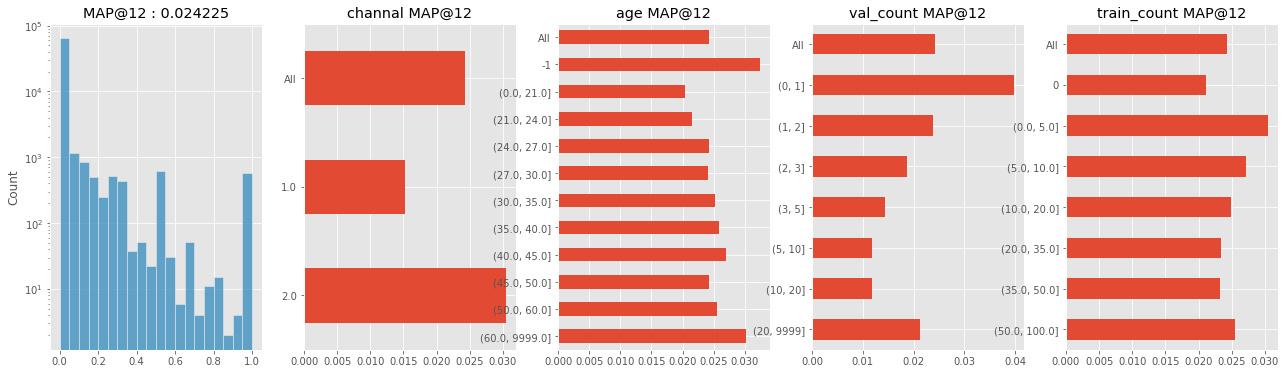

In [139]:
score = validation(real.article_id, prediction, groups, index='Last Purchase', ignore=0)

# 生成测试集

In [140]:
import datetime

In [141]:
if Last_date == "2020-09-22":
    sub[["customer_id", "prediction"]].to_csv("sub_sz_{}.csv".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')), index = False)